In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from celluloid import Camera
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge

from lineartree import LinearForestClassifier

In [3]:
### UTILITY FUNCTION TO GENERATE DATA ###

def gen_timeseries_dataset(n_samples, n_features, level=0, random_state=0):

    np.random.seed(random_state)
    
    X = np.sin(np.random.normal(0,1, (n_samples,n_features)))
    X = np.cumsum(X, axis=0)
    X += level
    
    coef = np.exp(np.random.uniform(0,2, n_features))-1
    y = X.dot(coef)
    
    return X,y

In [4]:
### UTILITY VARIABLES ###

thresholds = [0,-0.1,-0.2,-0.3,-0.4]
models = ['RF', 'RF_STACK_OOB', 'LINEAR_RF']
f_scoring = {m:{t:[] for t in thresholds} for m in models}
p_scoring = {m:{t:[] for t in thresholds} for m in models}
r_scoring = {m:{t:[] for t in thresholds} for m in models}

boxplotcolorprop = lambda c: {
    'medianprops':{'c':'lime', 'linewidth':1.5}, 
    'boxprops':{'c':c}, 
    'whiskerprops':{'c':c}, 
    'capprops':{'c':c}
}

scores2str = lambda scores,name : \
    name.ljust(11,' ') + ' | ' + \
    ' | '.join([f"({t}): {str(round(np.mean(s),3)).ljust(5,'0')}" for t,s in scores.items()])

In [5]:
### GENERATE SAMPLE DATA ###

X,y = gen_timeseries_dataset(n_samples=20_000, n_features=10, level=100, random_state=1)

X.shape, y.shape

((20000, 10), (20000,))

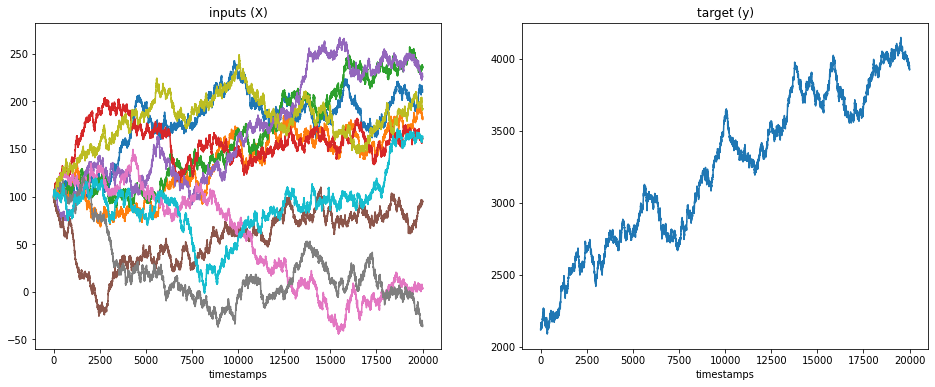

In [6]:
### PLOT GENERATED SAMPLE DATA ###

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(X)
plt.xlabel('timestamps'); plt.title('inputs (X)')
plt.subplot(122)
plt.plot(y)
plt.xlabel('timestamps'); plt.title('target (y)')
plt.show()

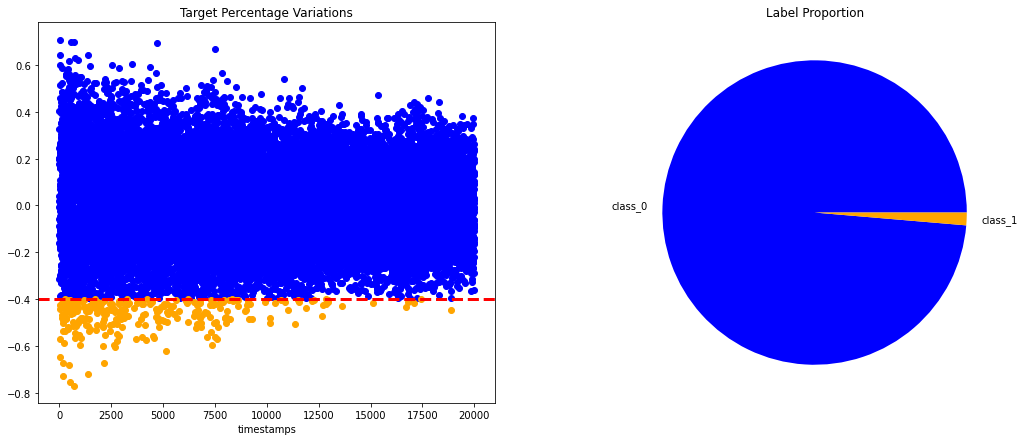

In [7]:
### SIMULATE LABEL GENERATION PROCESS AS FUNCTION OF THRESHOLD LEVEL ###

pct_change = np.diff(y)
pct_change = pct_change / y[:-1] *100
index = np.arange(len(pct_change))

fig = plt.figure(figsize=(18,7))
camera = Camera(fig)

for t in thresholds:
    class1 = pct_change<t
    class0 = pct_change>=t
    label_prop = pd.Series(pct_change < t).replace(
        {False:'class_0',True:'class_1'}).value_counts(sort=False)
    
    plt.subplot(121)
    plt.scatter(index[class0], pct_change[class0], c='blue')
    plt.scatter(index[class1], pct_change[class1], c='orange')
    plt.axhline(t, c='red', linestyle='--', linewidth=3)
    plt.xlabel('timestamps'); plt.title(f'Target Percentage Variations')
    
    plt.subplot(122)
    label_prop.plot.pie(colors = ['blue', 'orange'], ylabel='', title='Label Proportion')
    camera.snap()
    
animation = camera.animate()
animation.save('./animation.gif')

plt.show()

In [8]:
### FIT STANDARD RANDOM FOREST CLASSIFIER ###

trials = tqdm(range(100))

for i in trials:
    
    X,y = gen_timeseries_dataset(n_samples=6_000, n_features=10, level=100, random_state=i)
    
    y_change = np.diff(y)
    y_change = y_change / y[:-1] *100
    X = np.diff(X, axis=0)
    
    for t in thresholds:
        
        y = (y_change < t).astype(int)

        X_train, X_test, y_train, y_test = train_test_split(
            X,y, test_size=0.3, shuffle=False
        )

        model = RandomForestClassifier(n_estimators=100, random_state=33, n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)        
        f_scoring['RF'][t].append(f1_score(y_test, y_pred))
        p_scoring['RF'][t].append(precision_score(y_test, y_pred))
        r_scoring['RF'][t].append(recall_score(y_test, y_pred))
    
    desc = scores2str(f_scoring['RF'], 'F1')
    trials.set_description(desc)


print(scores2str(p_scoring['RF'], 'Precision'))
print(scores2str(r_scoring['RF'], 'Recall'))
print(scores2str(f_scoring['RF'], 'F1'))

F1          | (0): 0.931 | (-0.1): 0.899 | (-0.2): 0.845 | (-0.3): 0.743 | (-0.4): 0.591: 100%|██████████| 100/100 [05:49<00:00,  3.49s/it]

Precision   | (0): 0.935 | (-0.1): 0.935 | (-0.2): 0.939 | (-0.3): 0.938 | (-0.4): 0.941
Recall      | (0): 0.928 | (-0.1): 0.867 | (-0.2): 0.773 | (-0.3): 0.630 | (-0.4): 0.458
F1          | (0): 0.931 | (-0.1): 0.899 | (-0.2): 0.845 | (-0.3): 0.743 | (-0.4): 0.591


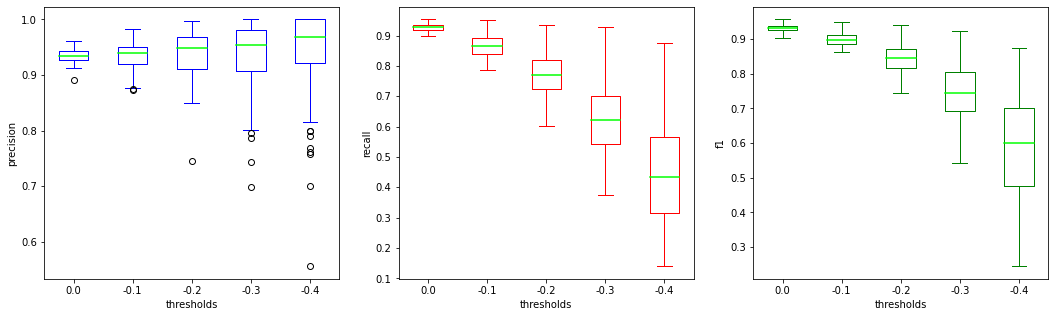

In [9]:
### STANDARD RANDOM FOREST CLASSIFIER PERFORMANCES ###

plt.figure(figsize=(18,5))
plt.subplot(131)
pd.DataFrame(p_scoring['RF']).plot.box(ax=plt.gca(), ylabel='precision', **boxplotcolorprop('blue'))
plt.xlabel('thresholds')
plt.subplot(132)
pd.DataFrame(r_scoring['RF']).plot.box(ax=plt.gca(), ylabel='recall', **boxplotcolorprop('red'))
plt.xlabel('thresholds')
plt.subplot(133)
pd.DataFrame(f_scoring['RF']).plot.box(ax=plt.gca(), ylabel='f1', **boxplotcolorprop('green'))
plt.xlabel('thresholds')
plt.show()

In [10]:
### FIT WEIGHTED RANDOM FOREST CLASSIFIER ###

trials = tqdm(range(100))

for i in trials:
    
    X,y = gen_timeseries_dataset(n_samples=6_000, n_features=10, level=100, random_state=i)
    
    y_change = np.diff(y)
    y_change = y_change / y[:-1] *100
    X = np.diff(X, axis=0)
    
    for t in thresholds:
        
        y = (y_change < t).astype(int)

        X_train, X_test, y_train, y_test = train_test_split(
            X,y, test_size=0.3, shuffle=False
        )

        model = RandomForestClassifier(n_estimators=100, random_state=33, oob_score=True, n_jobs=-1)
        model.fit(X_train, y_train)

        linear_reg = LogisticRegression()
        linear_reg.fit(model.oob_decision_function_, y_train)

        y_pred = linear_reg.predict(model.predict_proba(X_test))
        f_scoring['RF_STACK_OOB'][t].append(f1_score(y_test, y_pred))
        p_scoring['RF_STACK_OOB'][t].append(precision_score(y_test, y_pred))
        r_scoring['RF_STACK_OOB'][t].append(recall_score(y_test, y_pred))
    
    desc = scores2str(f_scoring['RF_STACK_OOB'], 'F1')
    trials.set_description(desc)

    
print(scores2str(p_scoring['RF_STACK_OOB'], 'Precision'))
print(scores2str(r_scoring['RF_STACK_OOB'], 'Recall'))
print(scores2str(f_scoring['RF_STACK_OOB'], 'F1'))

F1          | (0): 0.931 | (-0.1): 0.905 | (-0.2): 0.866 | (-0.3): 0.804 | (-0.4): 0.703: 100%|██████████| 100/100 [06:39<00:00,  3.99s/it]

Precision   | (0): 0.932 | (-0.1): 0.917 | (-0.2): 0.900 | (-0.3): 0.875 | (-0.4): 0.852
Recall      | (0): 0.931 | (-0.1): 0.895 | (-0.2): 0.841 | (-0.3): 0.759 | (-0.4): 0.633
F1          | (0): 0.931 | (-0.1): 0.905 | (-0.2): 0.866 | (-0.3): 0.804 | (-0.4): 0.703


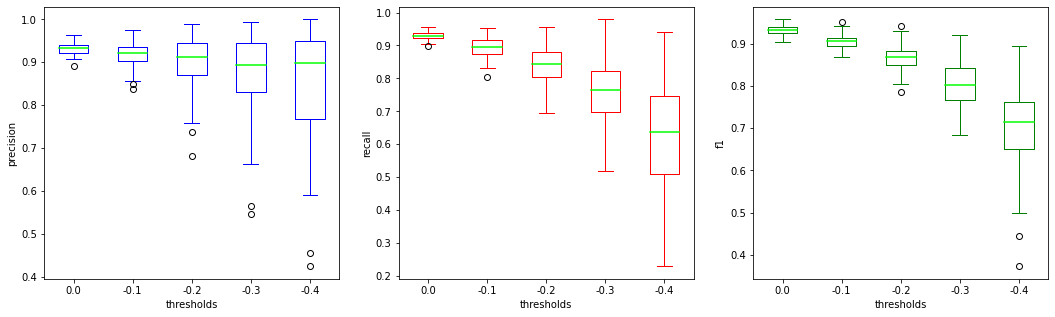

In [11]:
### WEIGHTED RANDOM FOREST CLASSIFIER PERFORMANCES ###

plt.figure(figsize=(18,5))
plt.subplot(131)
pd.DataFrame(p_scoring['RF_STACK_OOB']).plot.box(ax=plt.gca(), ylabel='precision', **boxplotcolorprop('blue'))
plt.xlabel('thresholds')
plt.subplot(132)
pd.DataFrame(r_scoring['RF_STACK_OOB']).plot.box(ax=plt.gca(), ylabel='recall', **boxplotcolorprop('red'))
plt.xlabel('thresholds')
plt.subplot(133)
pd.DataFrame(f_scoring['RF_STACK_OOB']).plot.box(ax=plt.gca(), ylabel='f1', **boxplotcolorprop('green'))
plt.xlabel('thresholds')
plt.show()

In [12]:
### FIT LINEAR RANDOM FOREST CLASSIFIER ###

trials = tqdm(range(100))

for i in trials:
    
    X,y = gen_timeseries_dataset(n_samples=6_000, n_features=10, level=100, random_state=i)
    
    y_change = np.diff(y)
    y_change = y_change / y[:-1] *100
    X = np.diff(X, axis=0)
    
    for t in thresholds:
        
        y = (y_change < t).astype(int)

        X_train, X_test, y_train, y_test = train_test_split(
            X,y, test_size=0.3, shuffle=False
        )

        model = LinearForestClassifier(Ridge(), n_estimators=100, random_state=33, n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        f_scoring['LINEAR_RF'][t].append(f1_score(y_test, y_pred))
        p_scoring['LINEAR_RF'][t].append(precision_score(y_test, y_pred))
        r_scoring['LINEAR_RF'][t].append(recall_score(y_test, y_pred))
    
    desc = scores2str(f_scoring['LINEAR_RF'], 'F1')
    trials.set_description(desc)

    
print(scores2str(p_scoring['LINEAR_RF'], 'Precision'))
print(scores2str(r_scoring['LINEAR_RF'], 'Recall'))
print(scores2str(f_scoring['LINEAR_RF'], 'F1'))

F1          | (0): 0.956 | (-0.1): 0.929 | (-0.2): 0.876 | (-0.3): 0.778 | (-0.4): 0.610: 100%|██████████| 100/100 [14:48<00:00,  8.88s/it]

Precision   | (0): 0.957 | (-0.1): 0.945 | (-0.2): 0.930 | (-0.3): 0.911 | (-0.4): 0.887
Recall      | (0): 0.956 | (-0.1): 0.914 | (-0.2): 0.834 | (-0.3): 0.693 | (-0.4): 0.496
F1          | (0): 0.956 | (-0.1): 0.929 | (-0.2): 0.876 | (-0.3): 0.778 | (-0.4): 0.610


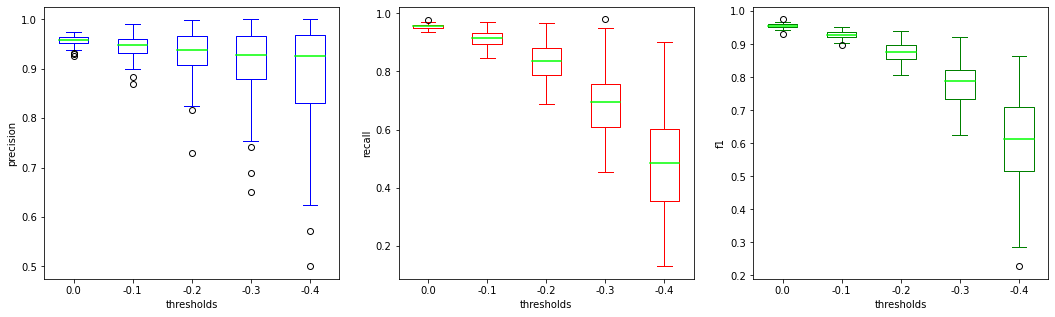

In [13]:
### LINEAR RANDOM FOREST CLASSIFIER PERFORMANCES ###

plt.figure(figsize=(18,5))
plt.subplot(131)
pd.DataFrame(p_scoring['LINEAR_RF']).plot.box(ax=plt.gca(), ylabel='precision', **boxplotcolorprop('blue'))
plt.xlabel('thresholds')
plt.subplot(132)
pd.DataFrame(r_scoring['LINEAR_RF']).plot.box(ax=plt.gca(), ylabel='recall', **boxplotcolorprop('red'))
plt.xlabel('thresholds')
plt.subplot(133)
pd.DataFrame(f_scoring['LINEAR_RF']).plot.box(ax=plt.gca(), ylabel='f1', **boxplotcolorprop('green'))
plt.xlabel('thresholds')
plt.show()

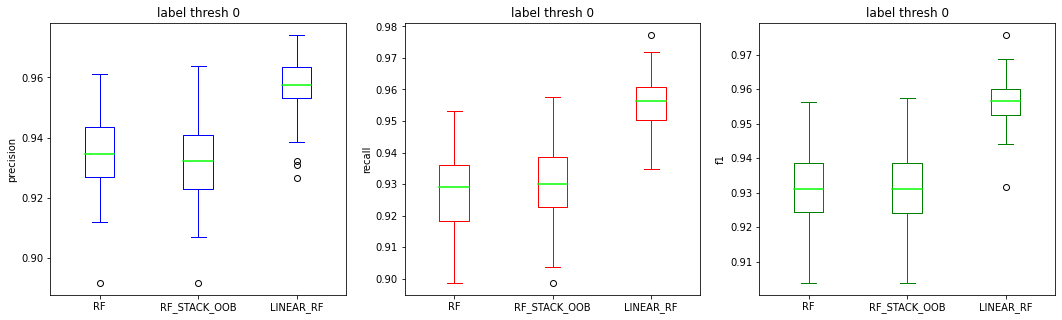

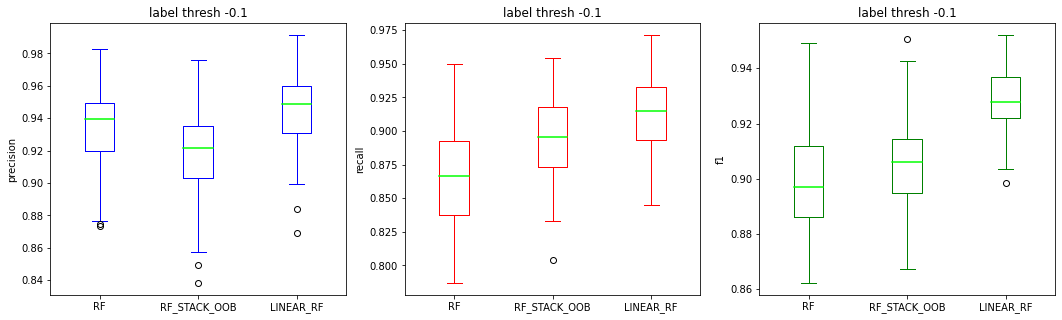

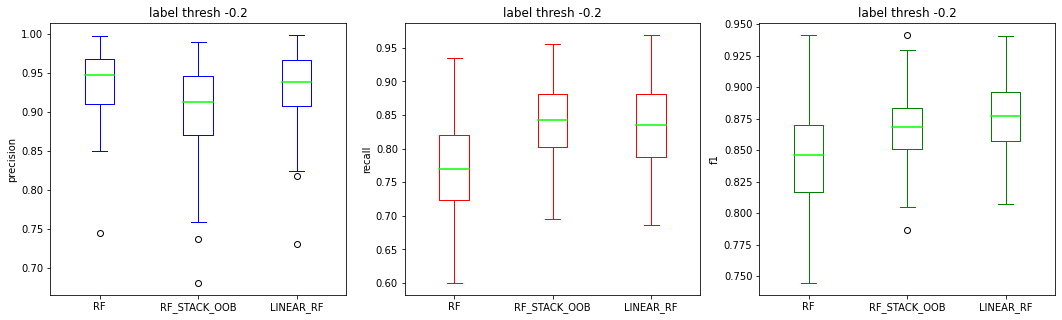

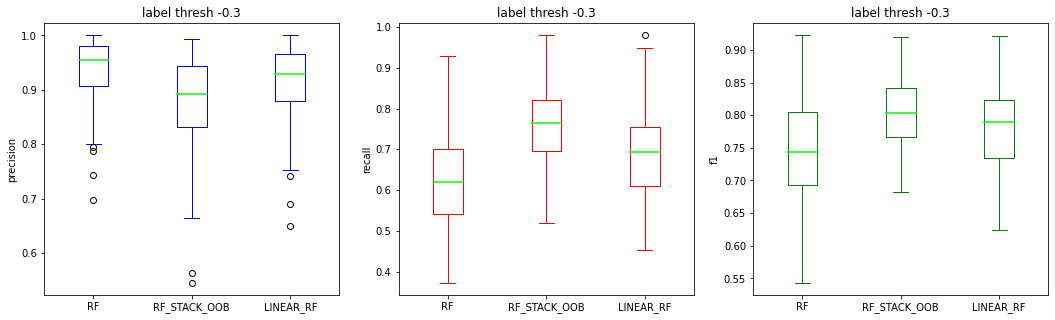

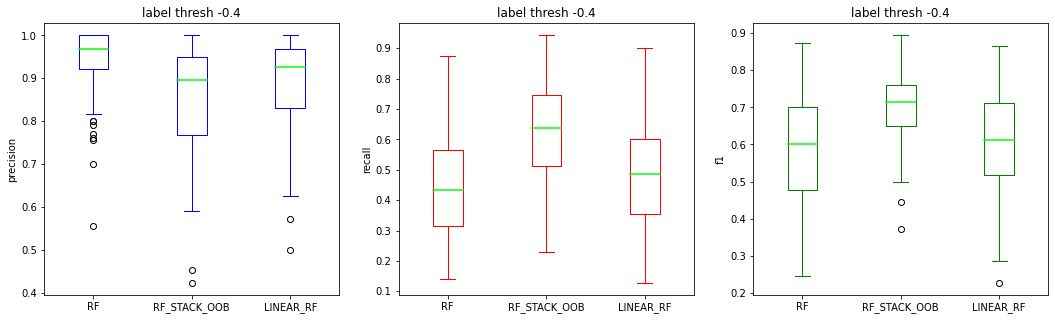

In [14]:
### PERFORMANCE COMPARISON ###

for t in thresholds: 
    plt.figure(figsize=(18,5))
    plt.subplot(131)
    pd.DataFrame({m: p_scoring[m][t] for m in models}).plot.box(
        ax=plt.gca(), title=f'label thresh {t}', ylabel='precision', **boxplotcolorprop('blue')
    )
    plt.subplot(132)
    pd.DataFrame({m: r_scoring[m][t] for m in models}).plot.box(
        ax=plt.gca(), title=f'label thresh {t}', ylabel='recall', **boxplotcolorprop('red')
    )
    plt.subplot(133)
    pd.DataFrame({m: f_scoring[m][t] for m in models}).plot.box(
        ax=plt.gca(), title=f'label thresh {t}', ylabel='f1', **boxplotcolorprop('green')
    )
    plt.show()
    print('\n\n')